In [1]:
import numpy as np

In [2]:
# forecast horizon (1 year)
H = 252

In [3]:
from data_loader import create_df

df = create_df("MSFT")
close_prices = df["Close"].values

data_len = len(close_prices)

# index where test period starts (raw data index)
test_start = data_len - (H)

train_data = close_prices[:test_start]
test_data  = close_prices[test_start:]

In [15]:
# log returns
daily_returns = np.diff(np.log(train_data))
recent_returns = daily_returns[-252:]

# drift
mu = daily_returns.mean()
mad = np.median(
    np.abs(recent_returns - np.median(recent_returns))
)
sigma = 1.4826 * mad

# start from last observed price
last_price = train_data[-1]

In [16]:
N = 1000
paths = np.zeros((N, H))

for i in range(N):
    price = last_price
    for t in range(H):
        price *= np.exp(mu + np.random.normal(0, sigma))
        paths[i, t] = price

mean_path = paths.mean(axis=0)
lower = np.percentile(paths, 5, axis=0)
upper = np.percentile(paths, 95, axis=0)

In [17]:
def directional_accuracy(y_true, y_pred):
    true_dir = np.sign(np.diff(y_true))
    pred_dir = np.sign(np.diff(y_pred))
    return np.mean(true_dir == pred_dir)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def stats_1d(y_real, y_pred):
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    da = directional_accuracy(y_real, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy: {da:.3f}")
    
stats_1d(test_data, mean_path)

RMSE: 31.7734
MAE: 26.8194
Directional Accuracy: 0.542


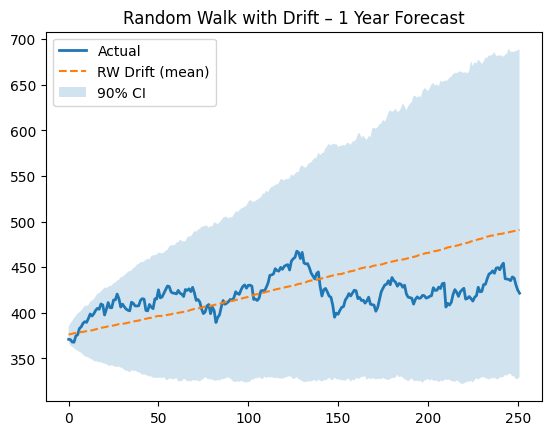

In [27]:
import matplotlib.pyplot as plt

plt.plot(test_data, label="Actual", linewidth=2)
plt.plot(mean_path, label="RW Drift (mean)", linestyle="--")
plt.fill_between(
    range(H), lower, upper, alpha=0.2, label="90% CI"
)
plt.legend()
plt.title("Random Walk with Drift – 1 Year Forecast")
plt.show()